In [1]:
import numpy as np
import pandas as pd

from os.path import join
from os import makedirs
from glob import glob
import re

from tqdm import tqdm

import scipy.io

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import patches
from matplotlib import animation, rc

In [2]:
dir_behav = '/mnt/ext5/GP/behav_data'
dir_record = join(dir_behav, 'records')
makedirs(dir_record, exist_ok=True)

In [3]:
dir_reg = join(dir_behav, 'regressors/AM/5s_shifted')
makedirs(dir_reg, exist_ok=True)

shift = int(*re.findall(r'\d+', dir_reg.split('/')[-1]))
print(shift)

5


In [154]:
list_group = ['DLPFC_cTBS','M1_cTBS','DLPFC_20Hz']

In [5]:
list_DLPFC_cTBS = [
    '09', '10', '18', '21', '22'
    , '24', '27', '34', '35', '36'
    , '38', '42', '57', '59', '62'
    , '66', '67'
]
list_M1_cTBS = [
    '08', '11', '17', '19', '20'
    , '26', '32', '33', '37', '39'
    , '40', '41', '56', '58', '61'
    , '63', '65'
]
## GP50 = GP26
list_DLPFC_20Hz = [
    '43', '44', '45', '46', '47'
    , '48', '49', '51', '53', '54'
    , '55', '71', '72', '73', '74'
    , '75'
#     , '50'
]
list_subj = sorted(np.concatenate((list_DLPFC_cTBS, list_M1_cTBS, list_DLPFC_20Hz)))

In [6]:
def convert_ID(ID):
    ##################   ##################
    #  1  2  3  4  5 #   #        2       #
    #  6  7  8  9 10 #   #        1       #
    # 11 12 13 14 15 # = # -2 -1  0  1  2 #
    # 16 17 18 19 20 #   #       -1       #
    # 21 22 23 24 25 #   #       -2       #
    ##################   ##################
    x = np.kron(np.ones(5),np.arange(-2,3)).astype(int)
    y = np.kron(np.arange(2,-3,-1),np.ones(5)).astype(int)
    pos = np.array((x[ID-1],y[ID-1]))
    return pos

In [189]:
tpr = 97
nrun = 3
sec = 5
sample_rate = 60*sec*tpr*nrun

def get_hit_frame(subj):
    ## target ID
    datum = scipy.io.loadmat(join(dir_behav, '%s-fmri.mat'%subj))
    tmp = datum['targetID']
    targetID = tmp[tmp!=0][:tpr*nrun]
    
    ## box
    bx = datum['boxSize']
    pos = bx*convert_ID(targetID) # (posision, trial)
    
    ## cursor
    allXY = datum['allXY']
    assert allXY.shape == (2,sample_rate)
    
    ## frame
    xFrame, yFrame = np.array([datum['xFrame'].squeeze(), datum['yFrame'].squeeze()]).astype(int)
    
    ## is it hit?
    tmp = np.zeros(allXY.shape)
    for i in range(sample_rate):
        t = np.floor(i/(60*sec)).astype(int)
        tmp[0][i], tmp[1][i] = pos[0][t], pos[1][t]
    err = abs(allXY - tmp)
    # hit = np.zeros(sample_rate)
    hit = (err[0] <= bx*.5) * (err[1] <= bx*.5)
    
    return hit.flatten(), allXY, (bx, xFrame, yFrame, targetID)

## Load Data

In [214]:
df = pd.DataFrame()
for nn in list_subj:
    group = 'DLPFC_cTBS' if nn in list_DLPFC_cTBS else ('M1_cTBS' if nn in list_M1_cTBS else ('DLPFC_20Hz' if nn in list_DLPFC_20Hz else 'invalid'))

    subj = 'GP%s'%nn
    hit, allXY, (_, _, _, target) = get_hit_frame(subj)

    for run in range(nrun):
        for trial in range(tpr):
            if trial == 0:
                continue
            block = (trial-1)//12
            idx = run*tpr + trial
            frame = 60*sec*idx
            hitted = hit[frame:frame+300]
            sample_x = allXY[0][frame:frame+300][hitted]
            sample_y = allXY[1][frame:frame+300][hitted]
            sample_dx = np.diff(sample_x)
            sample_dy = np.diff(sample_y)
            sample_dr = np.sqrt(sample_dx*sample_dx + sample_dy*sample_dy)
            # plt.plot(sample_x, sample_y)
    
            hitted_sum = int(hitted.sum())
            if hitted_sum < 15:
                std_x = np.nan
                std_y = np.nan
                std_dr = np.nan
            else:
                std_x = np.std(sample_x)
                std_y = np.std(sample_y)
                std_dr = np.std(sample_dr)
    
            # print(idx, hitted.sum(), np.std(sample_x), np.std(sample_y))
            new_row = pd.Series(
                {
                    'subj':subj, 'group':group,
                    'run':run+1, 'block':run*8+(block+1), 'trial':idx, 'target':target[idx], 'hitted_sum':hitted_sum,
                    'std_x':std_x, 'std_y':std_y, 'std_dr':std_dr
                }
            )
            df = pd.concat(
                [df, new_row.to_frame().T]
                , axis='index'
                , ignore_index=True
            )
        # print('')
df

,subj,group,run,block,trial,target,hitted_sum,std_x,std_y,std_dr
0,GP08,M1_cTBS,1,1,1,5,0,NaN,NaN,NaN
1,GP08,M1_cTBS,1,1,2,25,110,15.688179,8.245761,3.695769
2,GP08,M1_cTBS,1,1,3,21,0,NaN,NaN,NaN
3,GP08,M1_cTBS,1,1,4,1,1,NaN,NaN,NaN
4,GP08,M1_cTBS,1,1,5,25,20,22.649319,22.086209,11.055089
...,...,...,...,...,...,...,...,...,...,...
14395,GP75,DLPFC_20Hz,3,24,286,25,3,NaN,NaN,NaN
14396,GP75,DLPFC_20Hz,3,24,287,1,232,5.716712,5.24698,0.828618
14397,GP75,DLPFC_20Hz,3,24,288,21,144,3.269354,5.16093,1.226938
14398,GP75,DLPFC_20Hz,3,24,289,5,44,12.443407,3.472393,1.748395


In [226]:
df_tmp = df.groupby(['subj','group','run','block','target']).agg({'hitted_sum':'sum','std_dr':'mean'}).reset_index()
df_tmp

,subj,group,run,block,target,hitted_sum,std_dr
0,GP08,M1_cTBS,1,1,1,4,NaN
1,GP08,M1_cTBS,1,1,5,30,21.156543
2,GP08,M1_cTBS,1,1,21,0,NaN
3,GP08,M1_cTBS,1,1,25,331,6.257823
4,GP08,M1_cTBS,1,2,1,0,NaN
...,...,...,...,...,...,...,...
4795,GP75,DLPFC_20Hz,3,23,25,0,NaN
4796,GP75,DLPFC_20Hz,3,24,1,456,1.438459
4797,GP75,DLPFC_20Hz,3,24,5,47,1.748395
4798,GP75,DLPFC_20Hz,3,24,21,501,0.907278


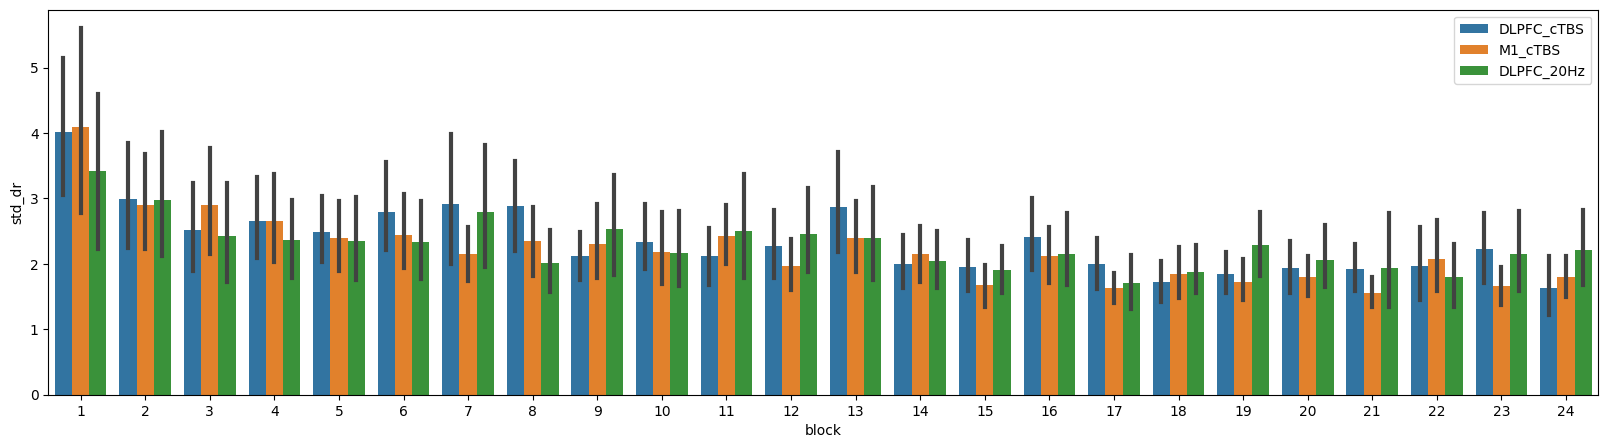

In [223]:
# nrows = 2
# fig, axs = plt.subplots(nrows=nrows, figsize=(150,5*nrows))

# sns.barplot(
#     data=df, x='trial', y='std_x',
#     hue='group', hue_order=list_group,
#     ax=axs[0]
# )
# sns.barplot(
#     data=df, x='trial', y='std_y',
#     hue='group', hue_order=list_group,
#     ax=axs[1]
# )

fig, ax = plt.subplots(figsize=(20,5))

sns.barplot(
    data=df_tmp, x='block', y='std_dr',
    hue='group', hue_order=list_group,
    ax=ax
)
ax.legend()

---

## Replay

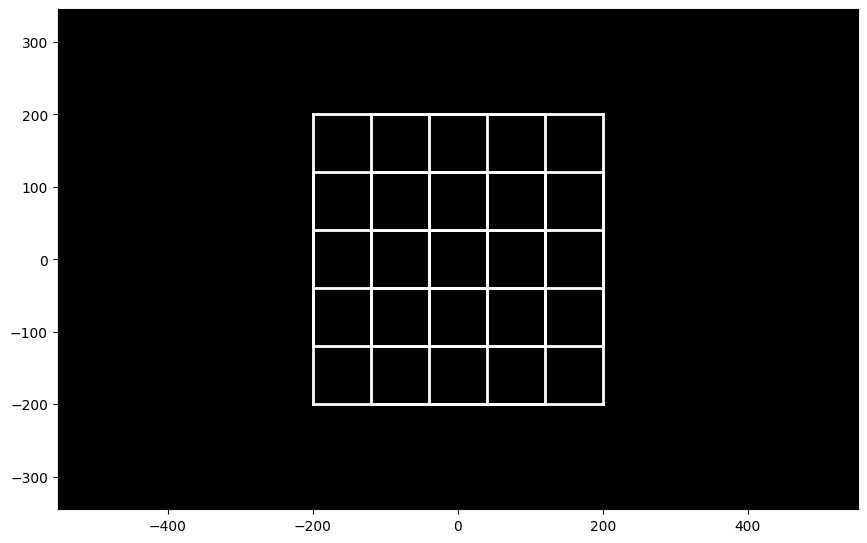

In [81]:
## 1440 * 900
ratio = [8, 5]

## Square
# ratio = [5, 5]

scale = 1
fig = plt.figure(figsize=ratio)
ax = plt.axes(xlim=np.array([-xFrame, xFrame])*ratio[0]/ratio[1]*scale, ylim=np.array([-yFrame, yFrame])*scale)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

## background
ax.set_facecolor((0., 0., 0.))

## grid
for x in [40, 120, 200]:
    for y in [40, 120, 200]:
        ax.plot([x,x], [-y,y], color='w', lw=2)
        ax.plot([-x,-x], [-y,y], color='w', lw=2)
        ax.plot([-x,x], [y,y], color='w', lw=2)
        ax.plot([-x,x], [-y,-y], color='w', lw=2)

live = []

In [82]:
def init():
    line, = ax.plot([], [], color='w', marker='+', markersize=12, lw=3)
    line.set_data([], [])
    
    target_unhit = patches.Rectangle([0, 0], 0, 0, fc='lightgray')
    target_hit = patches.Rectangle([0, 0], 0, 0, fc='crimson')
    
    live.append(line)
    live.append(ax.add_patch(target_unhit))
    live.append(ax.add_patch(target_hit))
    live.append(
        ax.text(
            -450, 200, '', ha='left', va='bottom'
            , fontsize=16, color='red', backgroundcolor='black'
        )
    )
    
    return live

In [84]:
## The anchor point (xy)
tmp = np.zeros(pos.shape)
tmp[0], tmp[1] = pos[0] - bx*.5, pos[1] - bx*.5

ap = np.zeros(allXY.shape)
for i in range(sample_rate):
    t = np.floor(i/(60*sec)).astype(int)
    ap[0][i], ap[1][i] = tmp[0][t], tmp[1][t]

def animate(i):

    live[0].set_data([allXY[0, i]], [allXY[1, i]])

    if hit[i]:
        live[1].set_width(0)
        live[1].set_height(0)
        live[1].set_xy([ap[0][i], ap[1][i]])
        
        live[2].set_width(bx)
        live[2].set_height(bx)
        live[2].set_xy([ap[0][i], ap[1][i]])
    else:
        live[1].set_width(bx)
        live[1].set_height(bx)
        live[1].set_xy([ap[0][i], ap[1][i]])
        
        live[2].set_width(0)
        live[2].set_height(0)
        live[2].set_xy([ap[0][i], ap[1][i]])
    
    quotient = i//300
    remainder = i%300
    
    trial = quotient + 1
    tmp = hit[300*quotient:i].sum()
    touch = 0.0167 * tmp
    reward = tmp/300
    
    live[3].set_text('Trial: %d\nTime: %.2fs\nHit: %.2fs\nReward: %.3f'%(trial, 0.0167*i, touch, reward))

    return live

In [77]:
print('%s'%subj)

rc('animation', html='html5')
anim

In [75]:
# anim.save(
#     join(dir_record,'%s_%s.r01.mp4'%(subj, group))
#     , writer = 'ffmpeg', fps=60
# )

---

In [85]:
# import matplotlib.pyplot as plt
# from matplotlib import animation, rc
# import numpy as np

# # 예제 데이터 생성 (실제 데이터로 대체하세요)
# allXY = np.random.rand(2, 1000) * 10

# # 그래프 설정
# fig, ax = plt.subplots()
# point, = ax.plot([], [], 'bo')  # 파란색 점

# # 축 설정
# ax.set_xlim(0, 10)
# ax.set_ylim(0, 10)

# # 초기화 함수
# def init():
#     point.set_data([], [])
#     return point,

# # 애니메이션 업데이트 함수
# def update(frame):
#     x = [allXY[0][frame]]
#     y = [allXY[1][frame]]
#     point.set_data(x, y)
#     return point,

# # 애니메이션 생성
# ani = animation.FuncAnimation(fig, update, frames=1000, init_func=init, blit=True)

# # 애니메이션 표시
# rc('animation', html='html5')